# Import libraries

In [46]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib

# Get data from api 
I get the weather data from ```https://archive-api.open-meteo.com/v1/archive``` this api. Furthermore in the below i am mentioning the peremeters i consider as features of dataset. 
- lantitude : 23.7204
- longitude : 90.40.74  
- start_date : 2010-08-10
- end_date : 2023-08-24
- features 
    - Maximum temperature (2m)
    - Minimum temperature (2m)
    - Maximum Wind Speed (10 m)
    - Maximum Wind Gusts (10 m)

In [47]:
import requests

# Define the API URL
api_url = "https://archive-api.open-meteo.com/v1/archive"

# Set the latitude and longitude for Dhaka
latitude = 23.7104
longitude = 90.4074

# Set the start and end dates
start_date = "2010-08-10"
end_date = "2023-08-24"

# Define the parameters for the API request
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    # "daily": "temperature_2m_max,temperature_2m_min,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant",
    "daily": "temperature_2m_max,temperature_2m_min,windspeed_10m_max,windgusts_10m_max",
    "timezone": "auto",
}

# Send a GET request to the API
response = requests.get(api_url, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
    # Process the data here
    df = pd.DataFrame(data['daily'])
else:
    print(f"Error: {response.status_code}")


In [48]:
df.shape

(4763, 5)

In [49]:
df.isna().sum()

time                  0
temperature_2m_max    0
temperature_2m_min    0
windspeed_10m_max     0
windgusts_10m_max     0
dtype: int64

In [50]:
df.dropna(inplace=True,axis=0)

In [51]:
# separate dates for future plottinh
train_dates = pd.to_datetime(df["time"])

In [52]:
print(train_dates.tail(15))

4748   2023-08-10
4749   2023-08-11
4750   2023-08-12
4751   2023-08-13
4752   2023-08-14
4753   2023-08-15
4754   2023-08-16
4755   2023-08-17
4756   2023-08-18
4757   2023-08-19
4758   2023-08-20
4759   2023-08-21
4760   2023-08-22
4761   2023-08-23
4762   2023-08-24
Name: time, dtype: datetime64[ns]


In [53]:
#variables for training 
cols = list(df)[1:]

In [54]:
cols

['temperature_2m_max',
 'temperature_2m_min',
 'windspeed_10m_max',
 'windgusts_10m_max']

In [55]:
df.columns

Index(['time', 'temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max',
       'windgusts_10m_max'],
      dtype='object')

# Data distribution 

In [56]:
#New dataframe with only training data - 4 columns
df_for_training = df[cols].astype(float)

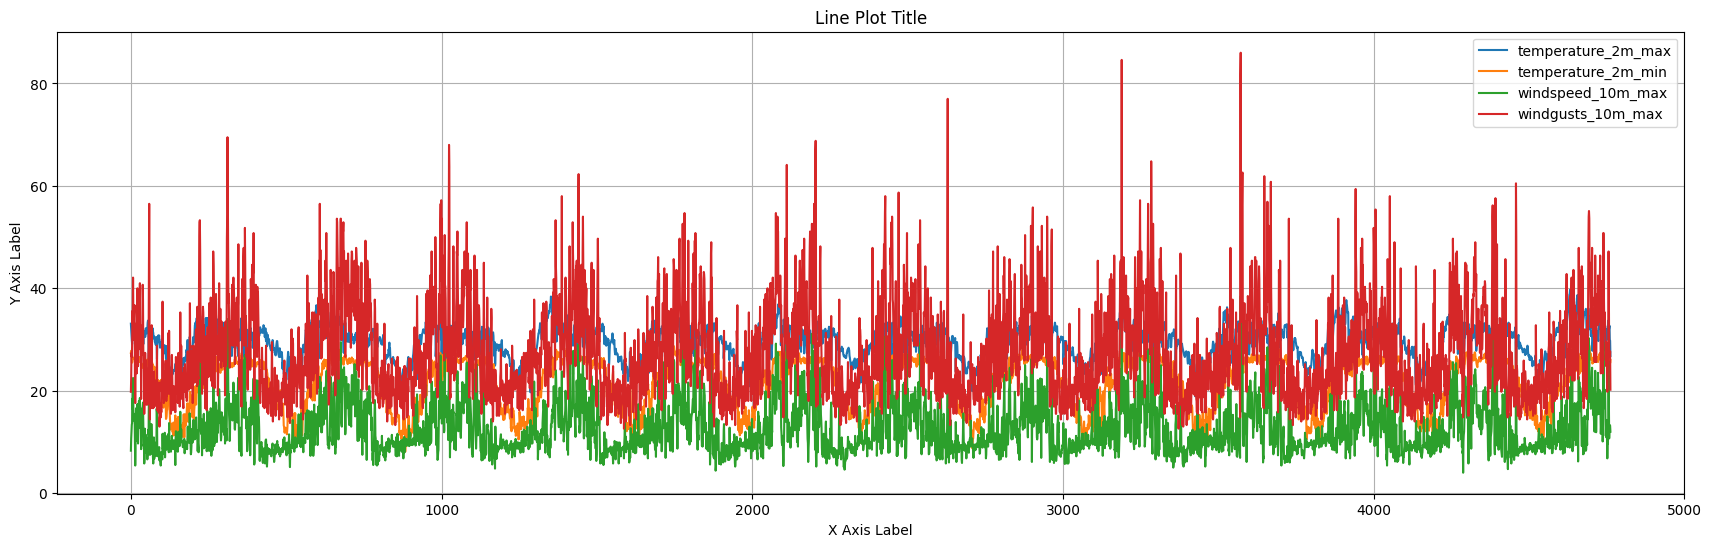

In [57]:
# Specify the figure size
plt.figure(figsize=(21, 6)) 

# Loop through each column and plot it on the same graph
for column in df_for_training.columns:
    plt.plot(df_for_training[column], label=column)

# Add labels and legend
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Line Plot Title')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Scale the dataset

In [58]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [59]:
# Save the scaler to a file
scaler_filename = "utils/scaler.pkl"
joblib.dump(scaler, scaler_filename)

['utils/scaler.pkl']

# split the data into X and Y
- X reprasent the features. here we have 4 features
- y represent the forecasting values.
##### Here, we are observing 14 number of days weather condition afterwards we will predict the 15 day's weather condition based on 14 days weather condition   

In [60]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []


In [61]:

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [62]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])


In [63]:
df_for_training_scaled[:16]

array([[ 1.07650098,  1.15581485, -0.88522016, -0.84304193],
       [ 0.7465657 ,  1.2380521 , -0.38598345, -0.52729239],
       [ 0.38663631,  0.99134037, -0.07396051, -0.01556037],
       [ 0.11668927,  0.76518795,  0.17565785, -0.10266369],
       [-0.12326366,  0.76518795,  0.23806244,  0.13687045],
       [ 0.50661277,  0.80630657,  1.23653586,  0.87724869],
       [ 0.53660689,  0.95022174,  0.79970374,  0.6050508 ],
       [ 0.26665985,  0.95022174,  2.06859704,  1.58496318],
       [ 0.65658335,  0.90910312,  0.84130679,  0.72481787],
       [ 0.56660101,  0.95022174,  0.34207008,  0.25663751],
       [ 0.44662454,  0.90910312,  0.61248997,  0.72481787],
       [ 0.62658924,  0.90910312,  0.46687926,  0.87724869],
       [ 0.65658335,  1.01189968,  0.50848232,  0.99701576],
       [ 0.86654217,  1.03245899, -0.51079263, -0.52729239],
       [ 0.98651863,  1.03245899, -1.48846452, -1.08257607],
       [ 0.86654217,  0.97078106, -0.80201405, -0.45107698]])

In [64]:
trainY

[array([0.98651863]),
 array([0.86654217]),
 array([0.56660101]),
 array([0.41663043]),
 array([0.35664219]),
 array([0.62658924]),
 array([0.47661866]),
 array([0.47661866]),
 array([0.56660101]),
 array([0.80655393]),
 array([0.53660689]),
 array([0.38663631]),
 array([0.35664219]),
 array([0.47661866]),
 array([0.47661866]),
 array([0.41663043]),
 array([0.08669515]),
 array([0.35664219]),
 array([0.41663043]),
 array([0.44662454]),
 array([0.23666573]),
 array([-0.33322248]),
 array([-0.30322836]),
 array([-0.09326955]),
 array([0.23666573]),
 array([0.1766775]),
 array([-0.12326366]),
 array([0.11668927]),
 array([0.41663043]),
 array([0.50661277]),
 array([0.65658335]),
 array([0.44662454]),
 array([0.29665396]),
 array([0.38663631]),
 array([0.80655393]),
 array([0.56660101]),
 array([0.7465657]),
 array([0.50661277]),
 array([0.56660101]),
 array([0.80655393]),
 array([1.13648921]),
 array([1.25646567]),
 array([1.07650098]),
 array([-0.81312833]),
 array([-1.3230283]),
 array(

In [65]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [66]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4749, 14, 4).
trainY shape == (4749, 1).


# Model architecture 
We choose LSTM.

In [67]:


model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='relu', return_sequences=True))  
# model.add(Dropout(0.1))
model.add(LSTM(16, activation='relu', return_sequences=True))  
model.add(LSTM(12, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            17664     
                                                                 
 dropout_2 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_6 (LSTM)               (None, 14, 16)            3136      
                                                                 
 lstm_7 (LSTM)               (None, 12)                1392      
                                                                 
 dropout_3 (Dropout)         (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [68]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/30
268/268 [==============================] - 5s 10ms/step - loss: 0.4137 - val_loss: 0.3315
Epoch 2/30
268/268 [==============================] - 2s 9ms/step - loss: 0.3143 - val_loss: 0.2793
Epoch 3/30
268/268 [==============================] - 2s 9ms/step - loss: 0.2556 - val_loss: 0.2630
Epoch 4/30
268/268 [==============================] - 3s 10ms/step - loss: 0.2097 - val_loss: 0.1894
Epoch 5/30
268/268 [==============================] - 2s 9ms/step - loss: 0.1956 - val_loss: 0.1850
Epoch 6/30
268/268 [==============================] - 3s 10ms/step - loss: 0.1786 - val_loss: 0.1503
Epoch 7/30
268/268 [==============================] - 2s 9ms/step - loss: 0.1695 - val_loss: 0.1626
Epoch 8/30
268/268 [==============================] - 2s 9ms/step - loss: 0.1666 - val_loss: 0.1450
Epoch 9/30
268/268 [==============================] - 2s 9ms/step - loss: 0.1570 - val_loss: 0.1745
Epoch 10/30
268/268 [==============================] - 2s 9ms/step - loss: 0.1610 - val_loss: 0.1

# Training loss VS validation loss

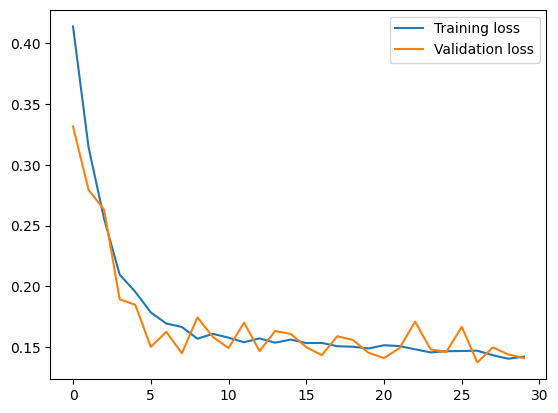

In [69]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [70]:
# Save the model to a file
model.save("utils/model.h5")

/home/sourav/miniconda3/envs/stativ/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Let's compair the model's prediction with original data.

In [71]:
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

In [72]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

[Timestamp('2023-08-09 00:00:00'), Timestamp('2023-08-10 00:00:00'), Timestamp('2023-08-11 00:00:00'), Timestamp('2023-08-12 00:00:00'), Timestamp('2023-08-13 00:00:00'), Timestamp('2023-08-14 00:00:00'), Timestamp('2023-08-15 00:00:00'), Timestamp('2023-08-16 00:00:00'), Timestamp('2023-08-17 00:00:00'), Timestamp('2023-08-18 00:00:00'), Timestamp('2023-08-19 00:00:00'), Timestamp('2023-08-20 00:00:00'), Timestamp('2023-08-21 00:00:00'), Timestamp('2023-08-22 00:00:00'), Timestamp('2023-08-23 00:00:00')]


In [73]:
prediction = model.predict(trainX[-n_days_for_prediction:])

1/1 [==============================] - 0s 271ms/step


In [74]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [75]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [76]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'temperature_2m_max':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [77]:
original = df[['time', 'temperature_2m_max']]
original['Date']=pd.to_datetime(original['time'])
original = original.loc[original['Date'] >= '2023-08-09']



/tmp/ipykernel_413926/2394950650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['time'])


In [78]:
df_forecast

,Date,temperature_2m_max
0,2023-08-09,31.836889
1,2023-08-10,31.308275
2,2023-08-11,31.499197
3,2023-08-12,31.159775
4,2023-08-13,30.892900
5,2023-08-14,31.876434
6,2023-08-15,31.945879
7,2023-08-16,32.080746
8,2023-08-17,32.567104
9,2023-08-18,31.200531


In [79]:
original

,time,temperature_2m_max,Date
4747,2023-08-09,31.8,2023-08-09
4748,2023-08-10,32.0,2023-08-10
4749,2023-08-11,31.7,2023-08-11
4750,2023-08-12,31.4,2023-08-12
4751,2023-08-13,30.0,2023-08-13
4752,2023-08-14,31.8,2023-08-14
4753,2023-08-15,32.6,2023-08-15
4754,2023-08-16,32.6,2023-08-16
4755,2023-08-17,33.7,2023-08-17
4756,2023-08-18,31.8,2023-08-18


# Original vs. Forecasted 

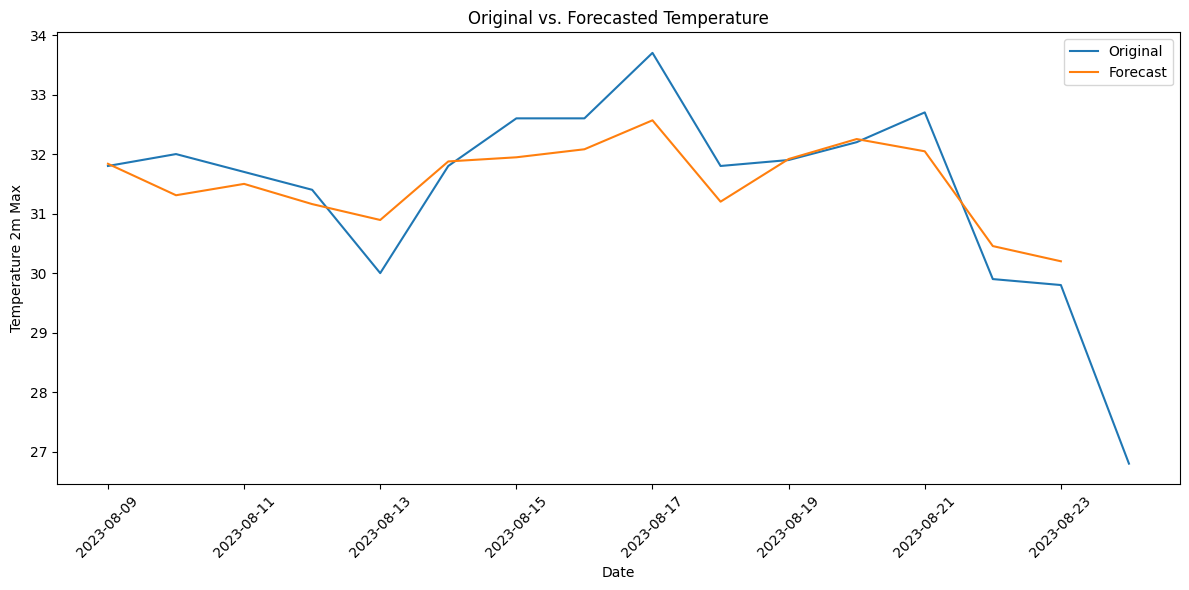

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
ax = sns.lineplot(data=original, x='Date', y='temperature_2m_max', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='temperature_2m_max', ax=ax, label='Forecast')

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Temperature 2m Max')
ax.set_title('Original vs. Forecasted Temperature')
ax.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Ensure that labels are not cut off
plt.show()


# Let's forecast next 90 days weather condition 

In [81]:
n_future = 90
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [82]:
forecast = model.predict(trainX[-n_future:])

3/3 [==============================] - 0s 4ms/step


In [83]:
forecast_copies = np.repeat(forecast,df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [84]:
y_pred_future

array([31.49513 , 31.753391, 32.831245, 33.23633 , 33.63644 , 33.80729 ,
       33.672245, 34.737576, 34.904873, 34.825043, 35.123703, 34.85638 ,
       34.54339 , 31.486382, 30.191805, 30.759068, 31.279234, 33.31526 ,
       32.9455  , 34.92759 , 33.47482 , 33.96916 , 33.67325 , 33.22582 ,
       31.59802 , 31.66153 , 31.916891, 30.823298, 31.42249 , 30.656935,
       30.943054, 30.434483, 29.559256, 29.689896, 30.55972 , 31.528965,
       30.954844, 32.135147, 31.995333, 32.458904, 31.46753 , 30.535187,
       30.422989, 30.796057, 31.887043, 30.373516, 30.858355, 31.48417 ,
       30.637075, 30.747135, 29.99917 , 30.057476, 31.32817 , 32.09875 ,
       31.801912, 31.965443, 31.397648, 31.96817 , 32.450737, 32.598686,
       32.48215 , 30.792847, 31.266832, 32.003906, 32.196163, 32.9101  ,
       32.887817, 31.552042, 30.647284, 31.337769, 31.070189, 31.16204 ,
       30.013712, 29.597609, 29.615925, 31.83689 , 31.308275, 31.499197,
       31.159775, 30.8929  , 31.876434, 31.945879, 

In [85]:
#convert timestamp to date
forecast_dates= []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [86]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'temp' : y_pred_future})
df_forecast['Data'] = pd.to_datetime(df_forecast['Date'])

In [87]:
original = df[['time', 'temperature_2m_max']]
original['Date']=pd.to_datetime(original['time'])
original = original.loc[original['Date'] >= '2023-08-08']

/tmp/ipykernel_413926/2165663633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['time'])


In [88]:
df_forecast

,Date,temp,Data
0,2023-08-24,31.495131,2023-08-24
1,2023-08-25,31.753391,2023-08-25
2,2023-08-26,32.831245,2023-08-26
3,2023-08-27,33.236328,2023-08-27
4,2023-08-28,33.636440,2023-08-28
...,...,...,...
85,2023-11-17,31.916611,2023-11-17
86,2023-11-18,32.252247,2023-11-18
87,2023-11-19,32.046654,2023-11-19
88,2023-11-20,30.454538,2023-11-20


In [89]:
original

,time,temperature_2m_max,Date
4746,2023-08-08,27.8,2023-08-08
4747,2023-08-09,31.8,2023-08-09
4748,2023-08-10,32.0,2023-08-10
4749,2023-08-11,31.7,2023-08-11
4750,2023-08-12,31.4,2023-08-12
4751,2023-08-13,30.0,2023-08-13
4752,2023-08-14,31.8,2023-08-14
4753,2023-08-15,32.6,2023-08-15
4754,2023-08-16,32.6,2023-08-16
4755,2023-08-17,33.7,2023-08-17


# Next 90 Days forecasting

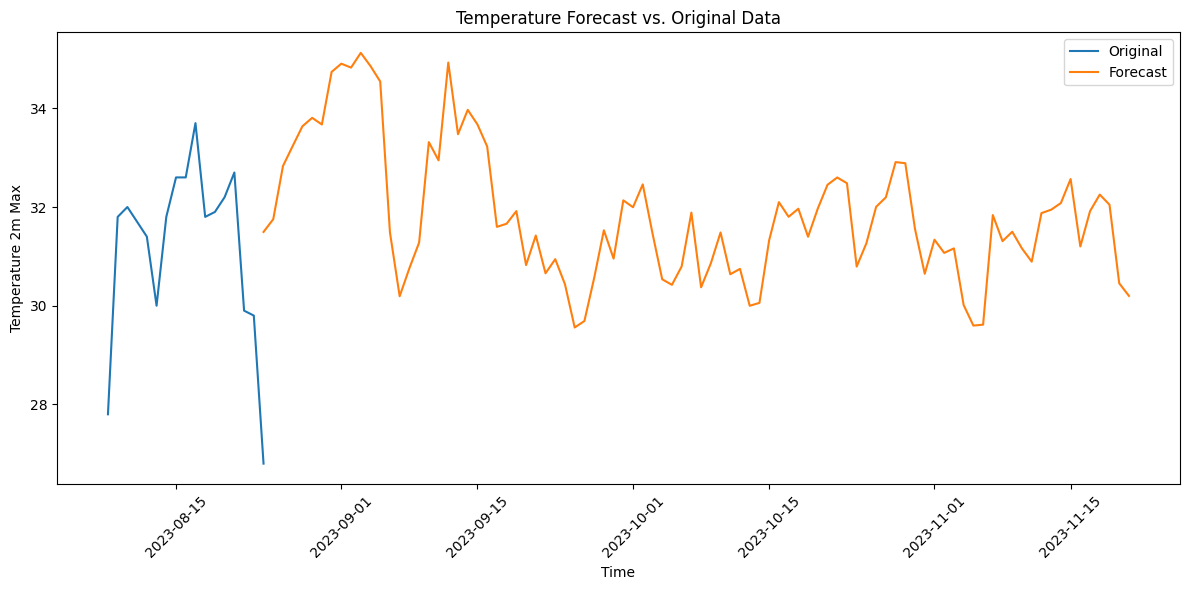

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
ax = sns.lineplot(data=original, x='Date', y='temperature_2m_max', label='Original')
sns.lineplot(data=df_forecast, x='Date', y='temp', label='Forecast', ax=ax)

# Set labels and legends
plt.xlabel('Time')
plt.ylabel('Temperature 2m Max')
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Optionally, rotate x-axis labels for better readability
plt.title('Temperature Forecast vs. Original Data')
plt.tight_layout()  # Ensure proper spacing
plt.show()
